In [290]:
import os
import torch
import wfdb
import numpy as np
import neurokit2 as nk
from tqdm import tqdm

train = [101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]
test = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]
skip = [102, 106, 107, 217]
all = train + test
data_folder = 'data/raw'

In [291]:
signals_train = []
for i in tqdm(train):
    signal, _ = wfdb.rdsamp(os.path.join(data_folder, f'{i}'))
    signals_train.append(signal)

signals_test = []
for i in tqdm(test):
    signal, _ = wfdb.rdsamp(os.path.join(data_folder, f'{i}'))
    signals_test.append(signal)

print('Signals loaded')

annotations_train = []
for i in tqdm(train):
    annotation = wfdb.rdann(os.path.join(data_folder, f'{i}'), 'atr')
    annotations_train.append(annotation)

annotations_test = []
for i in tqdm(test):
    annotation = wfdb.rdann(os.path.join(data_folder, f'{i}'), 'atr')
    annotations_test.append(annotation)

print('Annotations loaded')

100%|██████████| 22/22 [00:00<00:00, 77.64it/s]


Signals loaded


100%|██████████| 22/22 [00:00<00:00, 235.77it/s]

Annotations loaded


In [292]:
# for each patient, divide the signal every half peaks
def convert_label(symbol):
    if symbol in ['N', 'L', 'R', 'e', 'j']: 
        return 'N'
    elif symbol in ['A', 'a', 'J', 'S']:
        return 'S'  # Supraventricular ectopic
    elif symbol in ['V', 'E']: 
        return 'V'  # Ventricular ectopic
    elif symbol in ['F']: 
       return 'F'  # Fusion
    elif symbol in ['/', 'f', 'Q']:
        return 'Q'  # Unknown
    else:
        print(symbol)
        raise(f'Unknown symbol {symbol}') 
    

def create_samples(signals, annotations, data_folder='data/preprocessed_base/', subset='train', in_memory=False):
    valid_annotations = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']
    margin_perc = 0.1
    os.makedirs(data_folder + subset, exist_ok=True)
    processed_samples = []
    for i, (signal, annotation) in tqdm(enumerate(zip(signals, annotations))):
        peaks_orig = annotation.sample
        labels_orig = annotation.symbol
        
        valid = [(p, l) for l, p in zip(labels_orig, peaks_orig) if l in valid_annotations]
        # unzip the peaks and labels
        peaks, labels = zip(*valid)

        invalid = [(p, l) for l, p in zip(labels_orig, peaks_orig) if l not in valid_annotations]
        

        # count the number of different labels
        #label_count = {l: labels.count(l) for l in set(labels)}
        #print(f'Patient {i} has {label_count}')

        for j in range(0, len(peaks) - 1):
            # getting the points in the between of the two peaks
            start = 0 if j == 0 else (peaks[j] + peaks[j - 1]) // 2
            end = (peaks[j + 1] + peaks[j]) // 2 

            # add a margin to the signal, considering the space between the peaks
            margin_start = 0 if j == 0 else int((peaks[j] - peaks[j - 1]) * margin_perc)
            margin_end = int((peaks[j + 1] - peaks[j]) * margin_perc)

            start = max(0, start - margin_start)
            end = min(len(signal), end + margin_end)


            # get non valid annotations within the margin
            for inv_peak, inv_label in invalid:
                # invalid peak ']' at the beginning of the signal
                if (inv_label == ']' or inv_label+ '+') and inv_peak > start and inv_peak < peaks[j]:
                    start = inv_peak + 1
                # invalid peak '[' at the end of the signal
                if (inv_label == '[' or inv_label+ '+') and inv_peak < end and inv_peak > peaks[j]:
                    #print(f'Invalid peak at the end of the signal {inv_peak}')
                    end = inv_peak - 1
                    

            signal_part = signal[start:end]

            label = convert_label(labels[j])
            if not in_memory:
                # create file
                torch.save(torch.tensor(signal_part), os.path.join(data_folder + subset, f'{i}_{j}.pt'))   
                # Save the label to a CSV file
                with open(os.path.join(data_folder + subset, 'labels.csv'), 'a') as f:
                    f.write(f'{i}_{j},{label}\n')
            else:
                processed_samples.append((signal_part, label))

            #if len(signal_part) > 1000:
            #    print(f'Patient {i} has a sample with {len(signal_part)} samples at index {peaks[j]} from {start} to {end}')
        
    if in_memory: return processed_samples

create_samples(signals_train, annotations_train, data_folder='data/preprocessed_base/', subset='train')
create_samples(signals_test, annotations_test, data_folder='data/preprocessed_base/', subset='test')

16it [00:04,  3.30it/s]


KeyboardInterrupt: 

In [ ]:
# get some examples for debugging
processed_samples_train = create_samples(signals_train, annotations_train, data_folder='data/preprocessed_base/', subset='train', in_memory=True)
processed_samples_test = create_samples(signals_test, annotations_test, data_folder='data/preprocessed_base/', subset='test', in_memory=True)

20it [00:00, 55.97it/s]

Patient 12 has a sample with 1244 samples at index 137429 from 136627 to 137871
Patient 12 has a sample with 1163 samples at index 644594 from 643780 to 644943
Patient 15 has a sample with 1033 samples at index 591405 from 590913 to 591946


22it [00:00, 55.99it/s]
22it [00:00, 56.60it/s]

Patient 19 has a sample with 1025 samples at index 314706 from 314267 to 315292
Patient 19 has a sample with 1070 samples at index 342970 from 342807 to 343877
Patient 19 has a sample with 1182 samples at index 344483 from 343575 to 344757
Patient 19 has a sample with 1356 samples at index 352500 from 352029 to 353385
Patient 19 has a sample with 1152 samples at index 353976 from 353091 to 354243
Patient 19 has a sample with 1102 samples at index 370164 from 369645 to 370747
Patient 19 has a sample with 1433 samples at index 378481 from 378316 to 379749
Patient 19 has a sample with 1524 samples at index 380595 from 379327 to 380851
Patient 19 has a sample with 1124 samples at index 394055 from 393504 to 394628
Patient 19 has a sample with 1109 samples at index 396468 from 396311 to 397420
Patient 19 has a sample with 1214 samples at index 398056 from 397104 to 398318
Patient 19 has a sample with 1076 samples at index 401679 from 401204 to 402280
Patient 19 has a sample with 1046 sample

In [283]:
print(f'Patient 15 corresponds to recoded patient {train[15]}')
print(f'Patient 12 corresponds to recoded patient {train[12]}')
print(f'Patient 19 corresponds to recoded patient {test[19]}')

Patient 15 corresponds to recoded patient 207
Patient 12 corresponds to recoded patient 201
Patient 19 corresponds to recoded patient 232


Counter({'N': 45845, 'V': 3788, 'S': 943, 'F': 415, 'Q': 8})
Counter({'N': 44238, 'V': 3221, 'S': 1836, 'F': 388, 'Q': 7})
Average length: 332.47883291829254
Max length: 1244
Min length: 89
Samples longer than 1000:  3


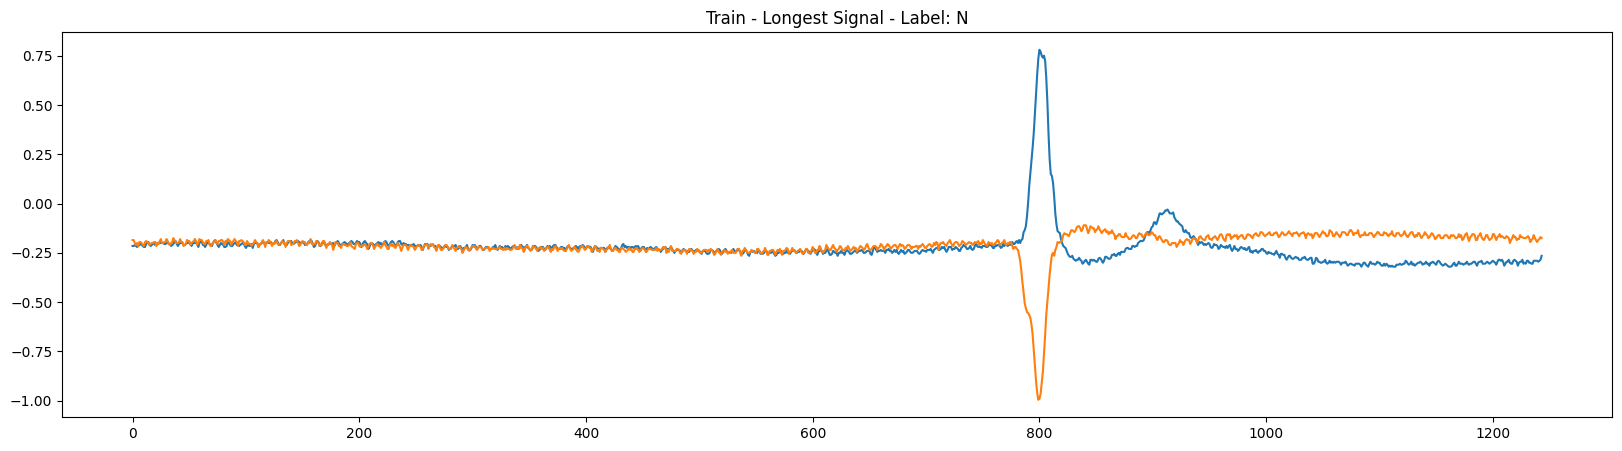

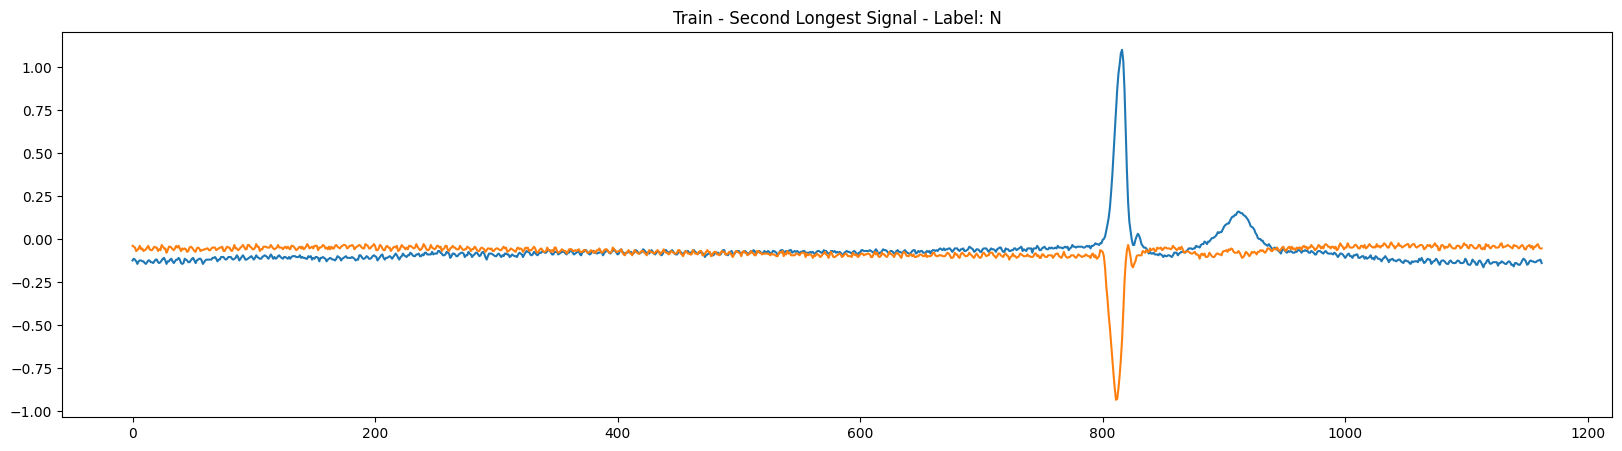

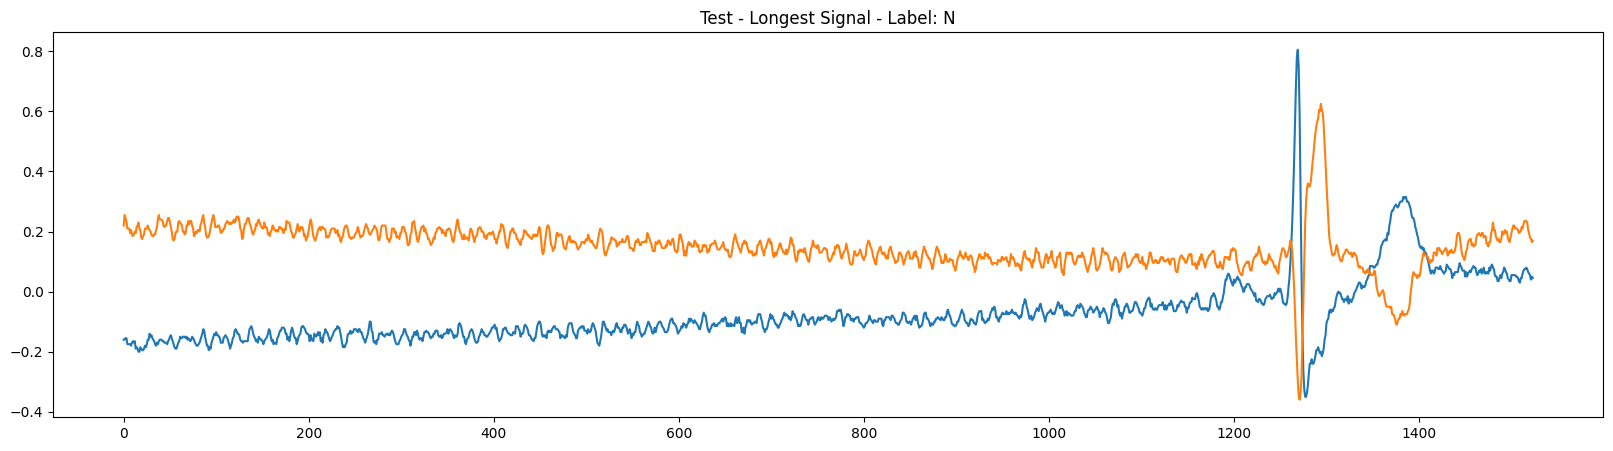

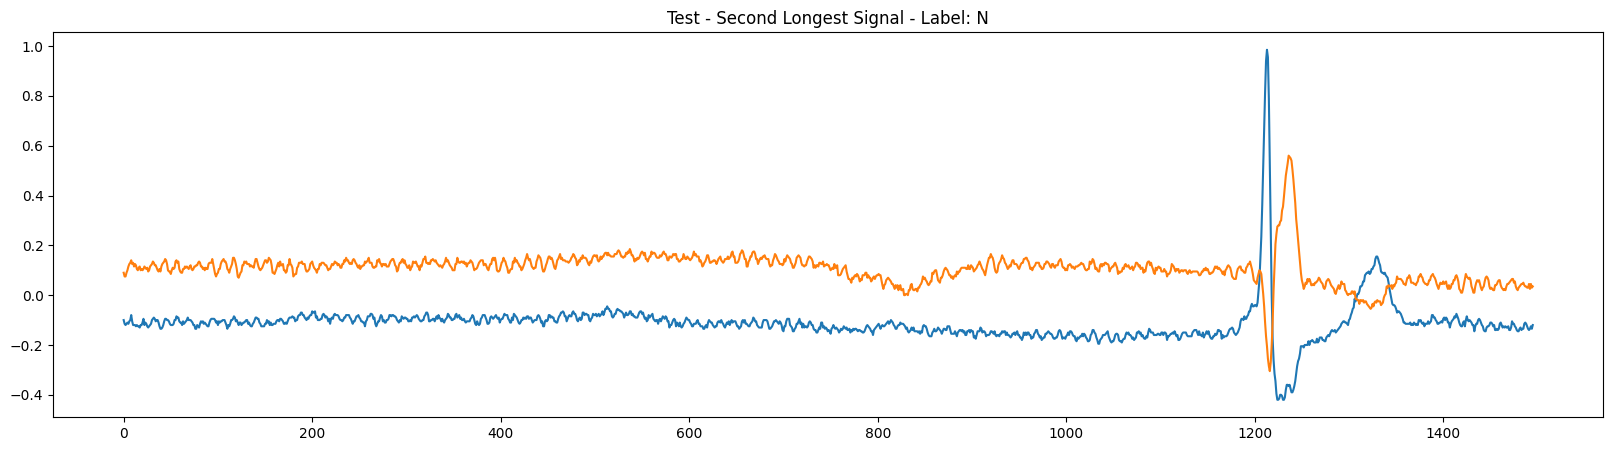

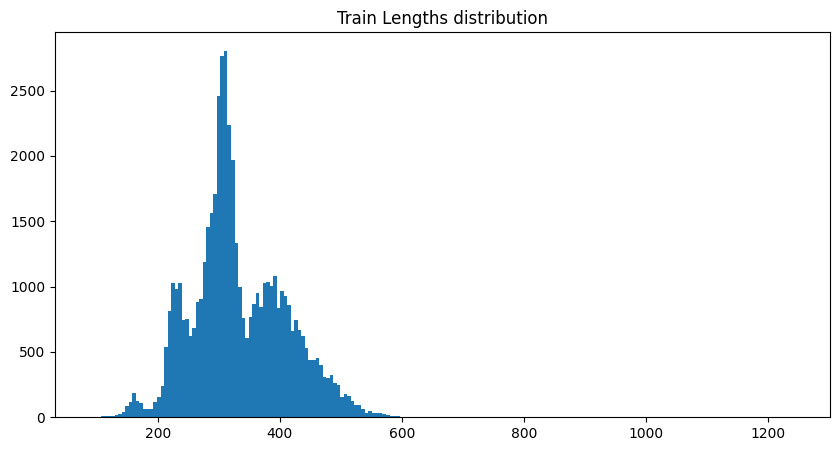

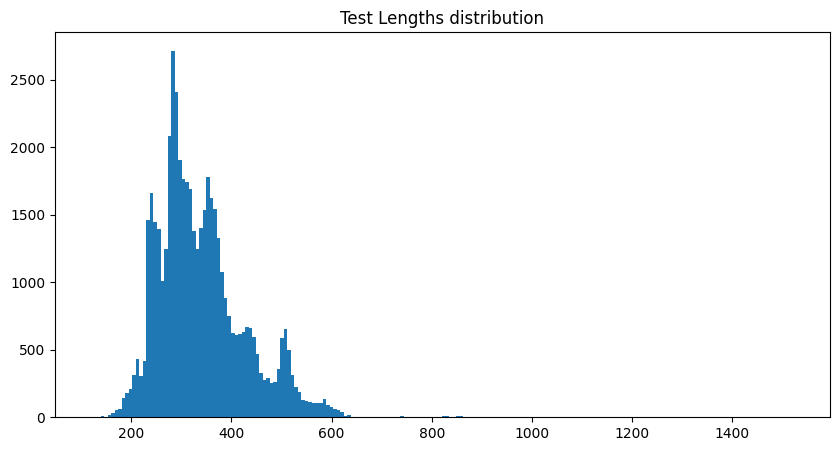

In [287]:
# count the number of samples for each class
from collections import Counter
labels = [label for _, label in processed_samples_train]
print(Counter(labels))

labels = [label for _, label in processed_samples_test]
print(Counter(labels))

# measure the average length of the samples as well as maximum and minimum
lengths = [len(signal) for signal, _ in processed_samples_train]
print(f'Average length: {np.mean(lengths)}')
print(f'Max length: {np.max(lengths)}')
print(f'Min length: {np.min(lengths)}')

# plot the longest signal
import matplotlib.pyplot as plt

# plot the longest signal from train
signal, label = processed_samples_train[np.argmax(lengths)]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Train - Longest Signal - Label: {label}')

# plot the second longest signal from train
signal, label = processed_samples_train[np.argsort(lengths)[-2]]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Train - Second Longest Signal - Label: {label}')

# plot the longest signal from test
lengths_test = [len(signal) for signal, _ in processed_samples_test]
signal, label = processed_samples_test[np.argmax(lengths_test)]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Test - Longest Signal - Label: {label}')

# plot the second longest signal from test
signal, label = processed_samples_test[np.argsort(lengths_test)[-2]]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Test - Second Longest Signal - Label: {label}')
# plot the distribution of the lengths for train
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=200)
plt.title('Train Lengths distribution')

# plot the distribution of the lengths for test
plt.figure(figsize=(10, 5))
plt.hist(lengths_test, bins=200)
plt.title('Test Lengths distribution')

# print the number of samples that has len bigger than 500
print('Samples longer than 1000: ', len([l for l in lengths if l > 1000]))


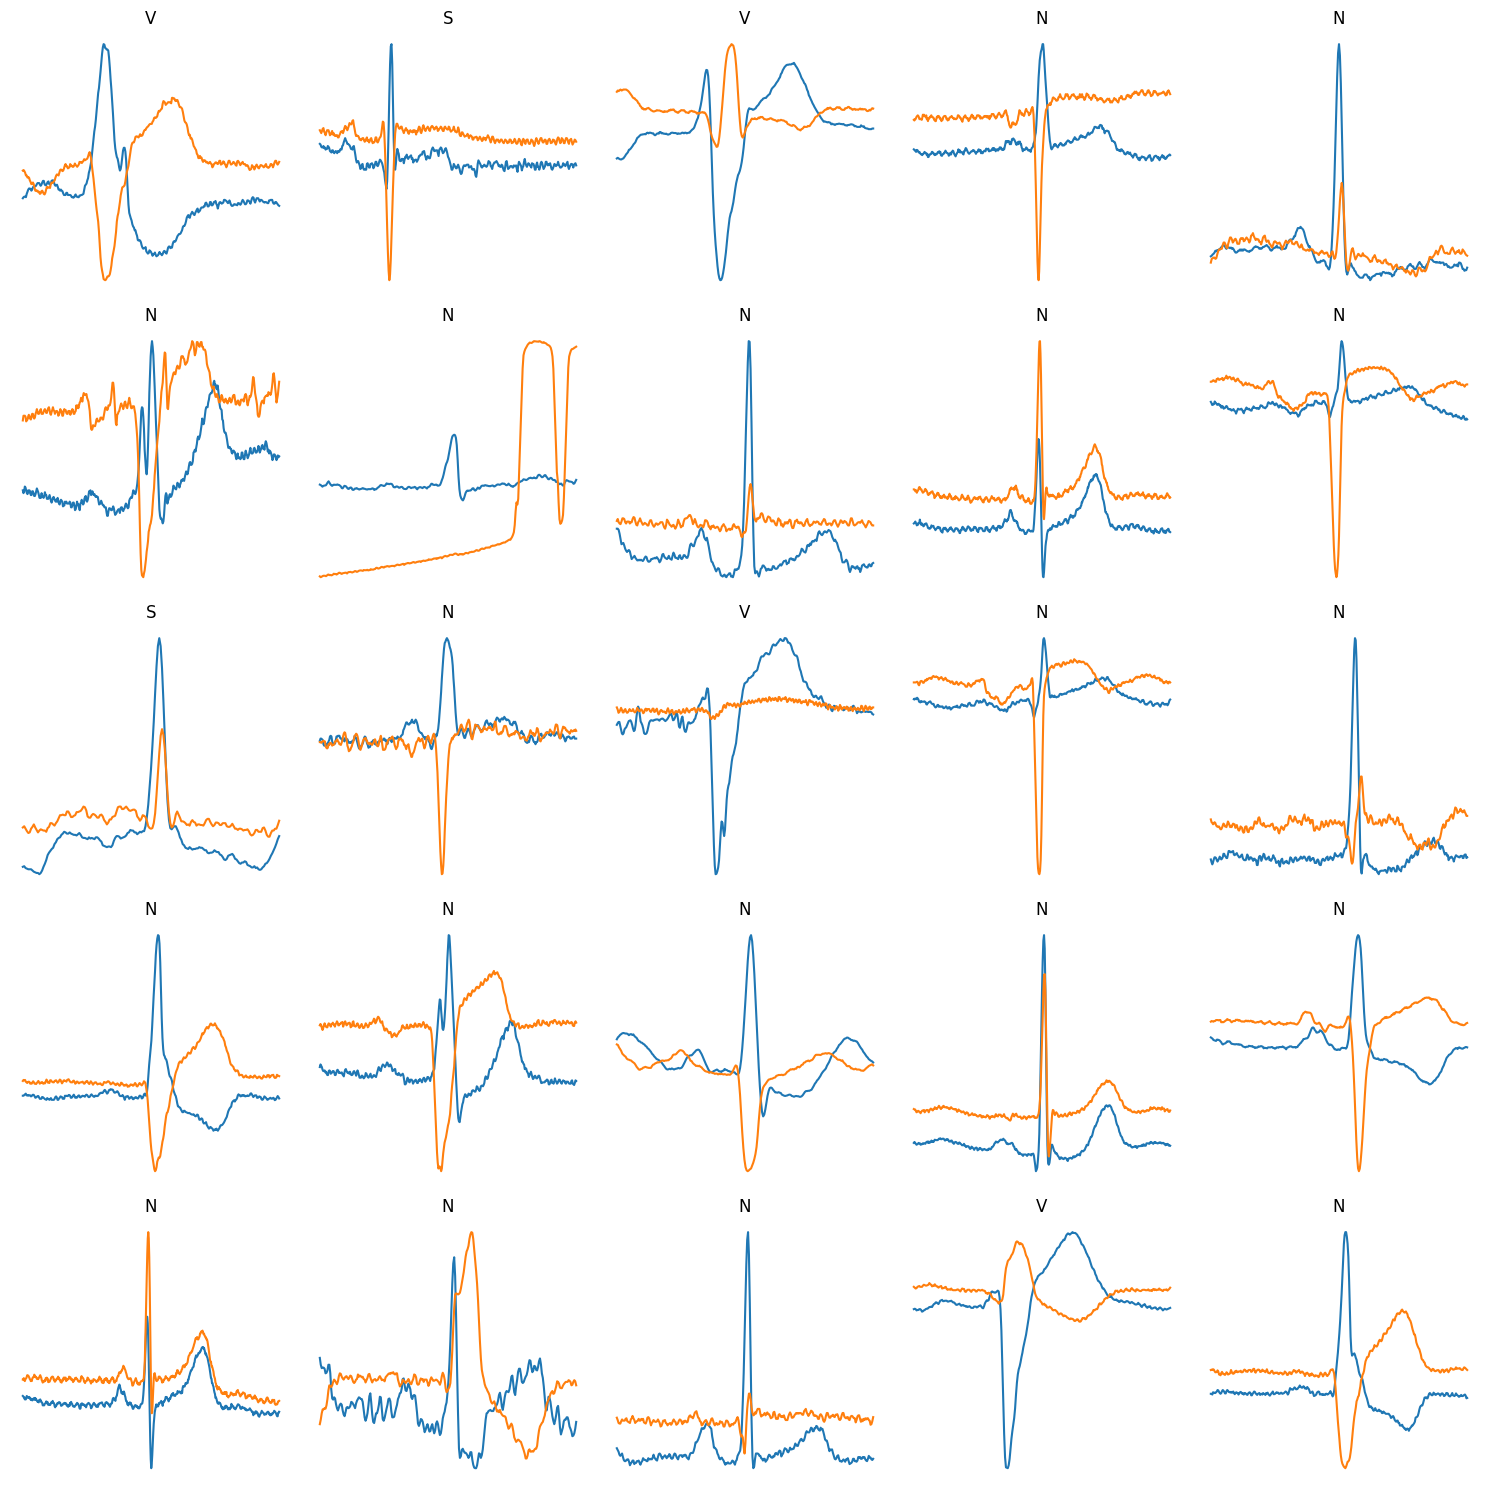

In [277]:
import random

# plot some processed samples in a grid
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

random_indices = random.sample(range(len(processed_samples_test)), 25)

for i, idx in enumerate(random_indices):
    signal, label = processed_samples_test[idx]
    axes[i].plot(signal)
    axes[i].set_title(label)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

annotation.symbol len: 1816
annotation.symbol: ['+', 'R', 'A', 'A', 'R', 'A', 'A', '~', 'R', 'A', 'R', 'A', 'R', 'A', 'R', 'A', 'A', 'R', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'R', 'R', 'R', 'A', 'A', 'R', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'R', 'R', 'A', 'A', 'R', 'A', 'A', 'A', 'R', 'R', 'A', 'A', 'A', 'A', 'A', 'R', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'A', 'A', 'A', 'R', '~', 'R', 'R', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'R', '~', 'A', 'A', 'A', 'R', 'A', 'A', '~', 'R', 'A', 'A', 'A', 'A', 'A', 'R', 'A', 'A', 'R', 'A', 'A', 'A', 'R', 'A', 'A', 'R', 'A', 'A', 'A', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'A', 'A', 'A', 'A', 'A', 'R', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'R', 'R', 'A', 'A', 'A', 'A', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'A', 'A', 'A', 'A', 'A', 'R', 'R', 'A', 'A', 'R', 'A', 'A', 'A', 'A', 'A', 'R', 'A', 'R', 'A', 'R', 'A', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'A

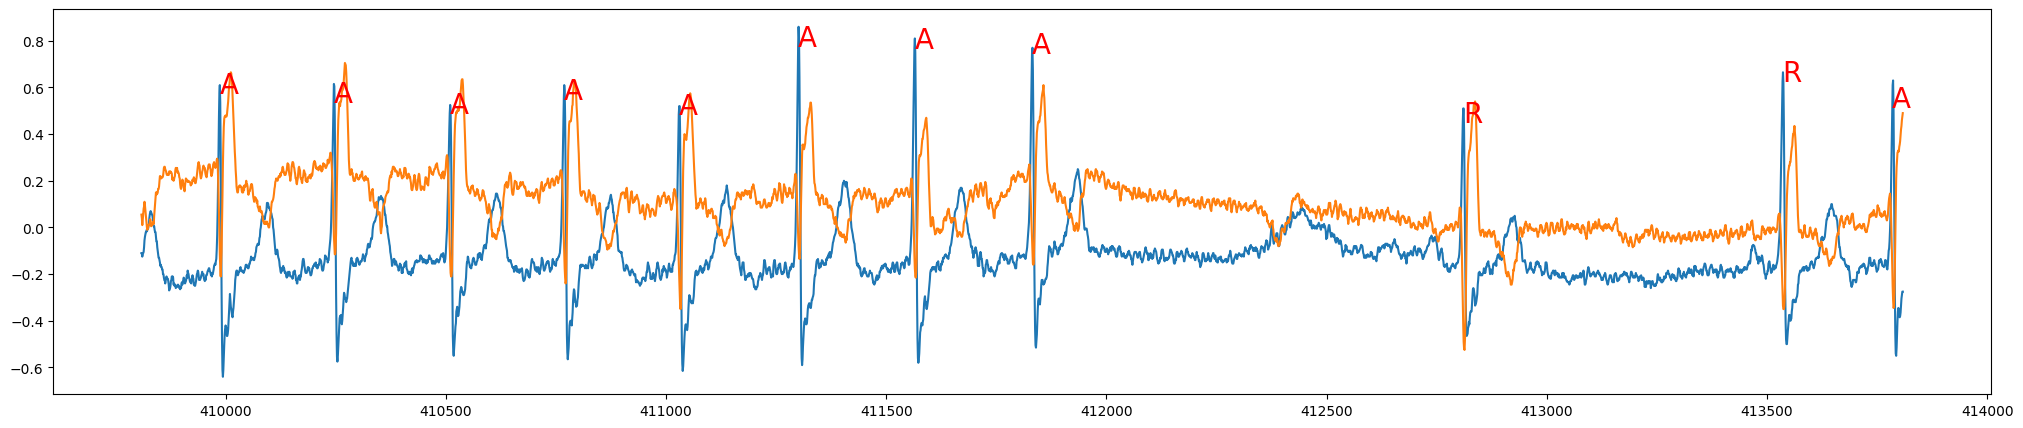

In [ ]:
import neurokit2 as nk

annotation = wfdb.rdann('data/raw/232', 'atr')
print(f'annotation.symbol len: {len(annotation.symbol)}')
print(f'annotation.symbol: {annotation.symbol}')
print(f'annotation.sample len: {len(annotation.sample)}')
print(f'annotation.sample: {annotation.sample}')

signal, _ = wfdb.rdsamp('data/raw/232')
print(f'signal len: {len(signal)}')
print(f'signal shape: {signal.shape}')

min_idx = 412809 - 3000
max_idx = 412809 + 1000

r_peaks = [s for s in annotation.sample if s < max_idx and s > min_idx]
print(f'r_peaks: {r_peaks}')

# signals, waves = nk.ecg_delineate(signal[min_idx:max_idx, 0], r_peaks, show=False, sampling_rate=360)

#nk.events_plot([waves["ECG_P_Offsets"]], signal[:2000, 0])
#print(f'waves: {waves.keys()}')

import matplotlib.pyplot as plt

# Plot the signal
plt.figure(figsize=(25, 5))
plt.plot(range(min_idx, max_idx), signal[min_idx:max_idx])
# print(f'signal[{min_idx}:{max_idx}, 0]: {signal[min_idx:max_idx,]}')

# Plot the annotation symbols
for symbol, sample in zip(annotation.symbol, annotation.sample):
    if sample < max_idx and sample > min_idx:  # Only plot symbols within the first 1000 samples
        print(f'{sample}: {symbol}')
        plt.text(sample, signal[sample, 0], symbol, color='red', fontsize=20)

plt.show()

In [293]:
# create the dataset class that will be used to train the model

class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, data_folder, subset='train'):
        self.data_folder = data_folder
        self.subset = subset
        self.samples = []
        with open(os.path.join(data_folder, subset, 'labels.csv'), 'r') as f:
            for line in f:
                sample, label = line.strip().split(',')
                self.samples.append((sample, label))

    def __len__(self):
        return len(self.samples)
    
    def get_label_int(self, label):
        if label == 'N': return 0
        if label == 'S': return 1
        if label == 'V': return 2
        if label == 'F': return 3
        if label == 'Q': return 4

    def __getitem__(self, idx):
        sample, label = self.samples[idx]
        signal = torch.load(os.path.join(self.data_folder, self.subset, f'{sample}.pt'))
        return signal, self.get_label_int(label)
    
# create the dataloaders
train_dataset = ECGDataset('data/preprocessed_base', subset='train')
test_dataset = ECGDataset('data/preprocessed_base', subset='test')

def collate_fn(batch):
    signals, labels = zip(*batch)
    signals = torch.nn.utils.rnn.pad_sequence(signals, batch_first=True)
    labels = torch.tensor([int(label) for label in labels])
    return signals, labels

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# get some samples from the dataloader
for i, (signal, label) in enumerate(train_dataloader):
    print(signal.shape)
    break


torch.Size([32, 666, 2])


/var/folders/6g/736tvbwn1k52163nfjyy6hcr0000gp/T/ipykernel_1781/510560712.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  signal = torch.load(os.path.join(self.data_fol